## Predict Product Prices with base qwen

Using base qwen (without any Fine-tuning) to predict amazon product prices from my hugging face dataset. This results helps us to evaluate pre and post fine tuning

# IMPORTANT please read me!!

When you run the pip installs below, you may get an error from pip complaining about an incompatible version of fsspec.

You should ignore that error! The version of fsspec is the right version, needed by HuggingFace.

If you ask ChatGPT, it will encourage you to pip install a more recent version of fsspec. But that would be problematic; HuggingFace will fail to load the dataset later with an obscure error about file systems.

So please run the pip installs as they appear below, and look the other way if you get an error!


In [ ]:
# pip installs - ignore the error message!

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 963.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = QWEN_2_5
HF_USER = "harish-anandaramanujam"
DATASET_NAME = f"{HF_USER}/amzn-appliances-price-lite-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

### Log in to HuggingFace

Make Sure HF_TOKEN in colab secrets point to huggingface account

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

# Comparing different Tokenizer

Just checking out how different tokenizers tokenize the input as visual output, instead of that's happening behind the scenes

In [ ]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [ ]:
# Now we will try this with each model: LLAMA_3_1, QWEN_2_5, GEMMA_2, PHI_3
# LLMA needs authorization to access through huggingface request

investigate_tokenizer(QWEN_2_5)

Investigating tokenizer for Qwen/Qwen2.5-7B


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

The tokens for 0: [15]
The tokens for 1: [16]
The tokens for 10: [16, 15]
The tokens for 100: [16, 15, 15]
The tokens for 999: [24, 24, 24]
The tokens for 1000: [16, 15, 15, 15]


In [ ]:
investigate_tokenizer(PHI_3)

Investigating tokenizer for microsoft/Phi-3-medium-4k-instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

The tokens for 0: [29871, 29900]
The tokens for 1: [29871, 29896]
The tokens for 10: [29871, 29896, 29900]
The tokens for 100: [29871, 29896, 29900, 29900]
The tokens for 999: [29871, 29929, 29929, 29929]
The tokens for 1000: [29871, 29896, 29900, 29900, 29900]


# Load data

Uploaded it to Hugging Face, so it's easy to retrieve it now

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/9.50M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/759k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nCONTINENTAL REFRIGERATOR 2-705 Gasket, SNAP in\nSPECIFICATIONS LENGTH 22 3/8, 568 mm WIDTH 25 3/8, 644 mm WEIGHT 1.225 lb GASKET TYPE 4 SIDED, MAGNETIC, DART PART REFERENCE INFO CONTINENTAL REFRIGERATOR 2-705 MODEL REFERENCE INFO CONTINENTAL REFRIGERATOR WORK TOP REFRIGERATOR MODELS SW48 CONTINENTAL REFRIGERATOR REFRIGERATOR DOOR GASKET 2-705 High Quality Gasket Brand Name Continental Refrigerator, Model Info Weight 1.2\n\nPrice is $',
 'price': 36.22}

# Prepare our Base Llama Model for evaluation

Load our base model with 4 bit quantization and try out 1 example

In [ ]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Memory footprint: 5.4 GB


Extract Prices from noise ( needed when we get the model output)

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
extract_price("Price is $999 blah blah so cheap")

999.0

# Model prediction

In [ ]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
model_predict(test[0]['text'])

1.22

# Evaluation!

Trying out our base qwen 2.5 model against the Test dataset

In [ ]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $1.22 Truth: $36.22 Error: $35.00 SLE: 7.95 Item: CONTINENTAL REFRIGER...
2: Guess: $129.00 Truth: $880.00 Error: $751.00 SLE: 3.66 Item: 12,000 BTU CoVac Duc...
3: Guess: $10.00 Truth: $95.67 Error: $85.67 SLE: 4.72 Item: Whirlpool Oven
Produ...
4: Guess: $10.90 Truth: $21.98 Error: $11.08 SLE: 0.43 Item: Frigidaire Basket
Th...
5: Guess: $10.90 Truth: $95.14 Error: $84.24 SLE: 4.37 Item: GE Genuine OEM Compr...
6: Guess: $12.90 Truth: $8.99 Error: $3.91 SLE: 0.11 Item: 6 Pack Reusable K Cu...
7: Guess: $10.90 Truth: $8.66 Error: $2.24 SLE: 0.04 Item: Silicone Kitchen Sto...
8: Guess: $10.90 Truth: $42.52 Error: $31.62 SLE: 1.68 Item: Whirlpool Refrigerat...
9: Guess: $19.90 Truth: $9.99 Error: $9.91 SLE: 0.41 Item: Oven Temperature Sen...
10: Guess: $10.90 Truth: $42.99 Error: $32.09 SLE: 1.71 Item: Upgraded Full Real M...
11: Guess: $10.00 Truth: $21.99 Error: $11.99 SLE: 0.54 Item: BUNN Basket Filter (...
12: Guess: $129.00 Truth: $53.98 Error: $75.02 SLE: 0.74 Item: Vuen

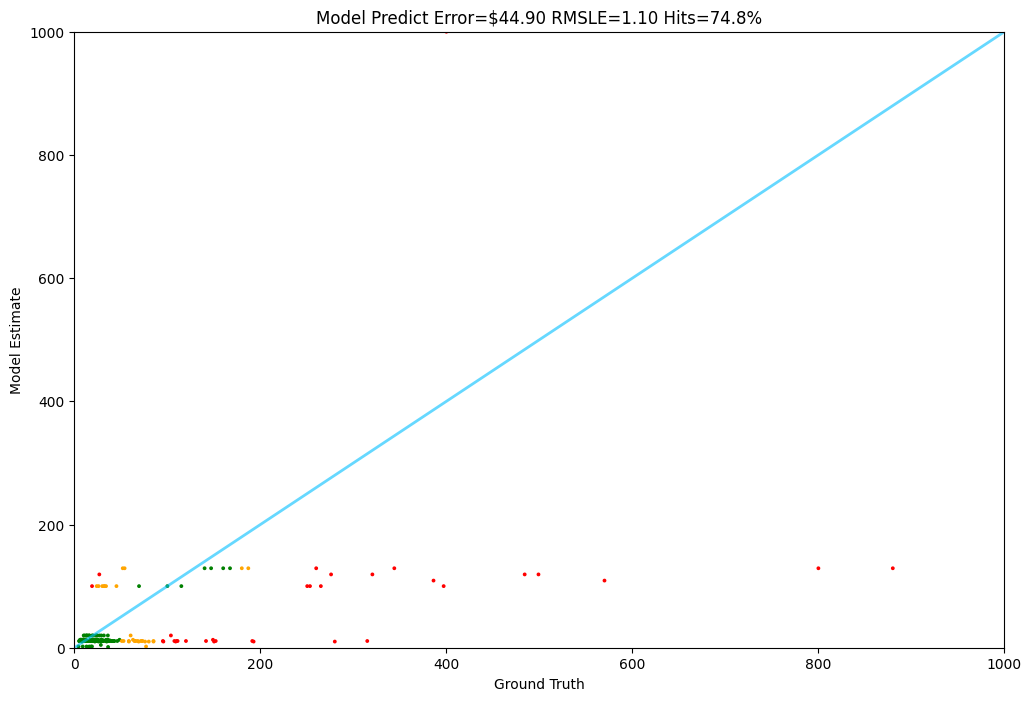

In [ ]:
Tester.test(model_predict, test)